# Loan Approval Prediction Modeling (Siphesihle Masuku)
## Objective

    The objective of this project is to build a classification model to predict whether a loan application will get approved based on applicant details.

## Dataset

    The data set contains details on loan applications with the following features:

#### Categorical: Gender, Marital Status, Education, Self Employed, Property Area
#### Numerical: Applicant Income, Co-Applicant Income, Loan Amount, Term, Credit History

    It has 381 rows and 13 features including the target variable Loan_Status which indicates if the application was approved or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

### Data Loading and Exploration:

In [2]:
loan_data = pd.read_csv('C:\\Users\\Administrator\\Documents\\Data Science Projects\\loan_data.csv')

In [3]:
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [4]:
#type of each column
loan_data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [5]:
#check for null values
loan_data.isnull().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
loan_data.notnull().sum()

Loan_ID              381
Gender               376
Married              381
Dependents           373
Education            381
Self_Employed        360
ApplicantIncome      381
CoapplicantIncome    381
LoanAmount           381
Loan_Amount_Term     370
Credit_History       351
Property_Area        381
Loan_Status          381
dtype: int64

### Data Cleaning:
    Rows with null values are dropped to keep only complete cases for modeling.

In [7]:
#drop null values
loan_data = loan_data.dropna()

In [8]:
loan_data.notnull().sum()

Loan_ID              308
Gender               308
Married              308
Dependents           308
Education            308
Self_Employed        308
ApplicantIncome      308
CoapplicantIncome    308
LoanAmount           308
Loan_Amount_Term     308
Credit_History       308
Property_Area        308
Loan_Status          308
dtype: int64

### Exploratory Data Analysis (Visualization):
    Visualizations are created to understand distributions of key numerical features. Charts showing breakdown of loan approval status by education level and credit history provide insights into important factors. A correlation matrix identifies relationships between numerical features.

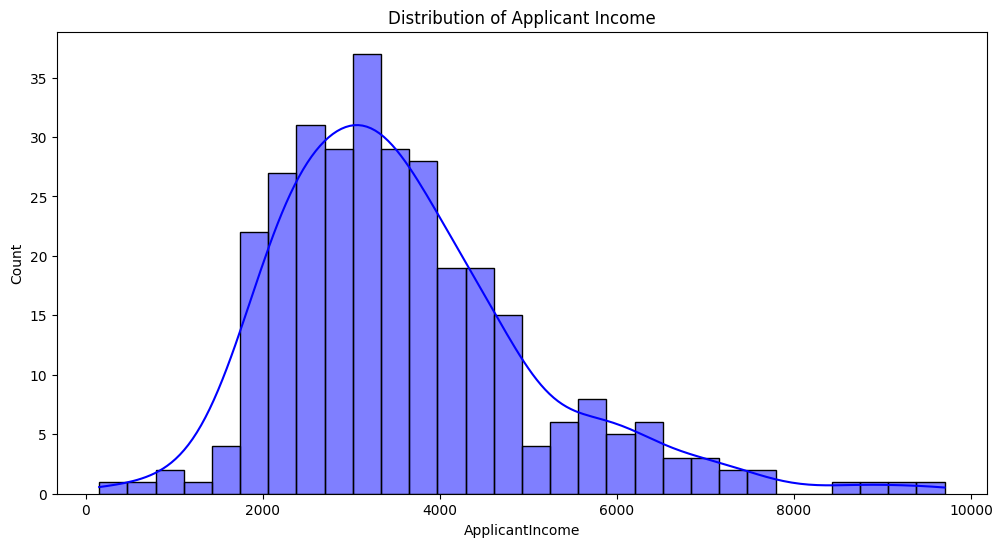

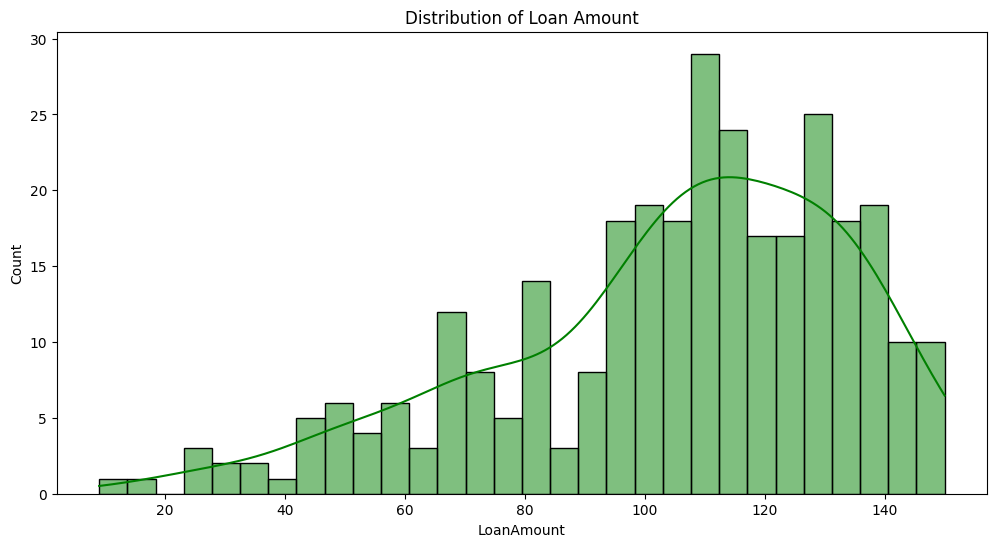

In [10]:
#distribution of ApplicantIncome and LoanAmount
plt.figure(figsize=(12, 6))
sns.histplot(loan_data['ApplicantIncome'], bins=30, kde=True, color='blue')
plt.title('Distribution of Applicant Income')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(loan_data['LoanAmount'], bins=30, kde=True, color='green')
plt.title('Distribution of Loan Amount')
plt.show()

#### Distribution of Applicant Income
Right-skewed income distributions are common and reflect the reality of income inequality. Most people tend to cluster around a more modest income range, while a smaller percentage of individuals earn extremely high incomes.

#### Distribution of Loan Amount
The left skew could reflect the general income distribution in the population. People with lower incomes might be more likely to take out smaller loans. On the other hand, people with higher incomes may have less need for loans in general, or may be able to qualify for larger loans, contributing to the smaller number of extremely high-value loans.

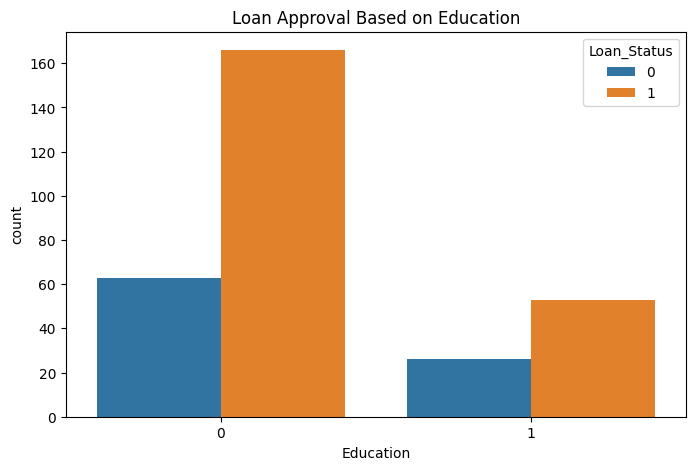

In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Education', hue='Loan_Status', data=loan_data)
plt.title('Loan Approval Based on Education')
plt.show()

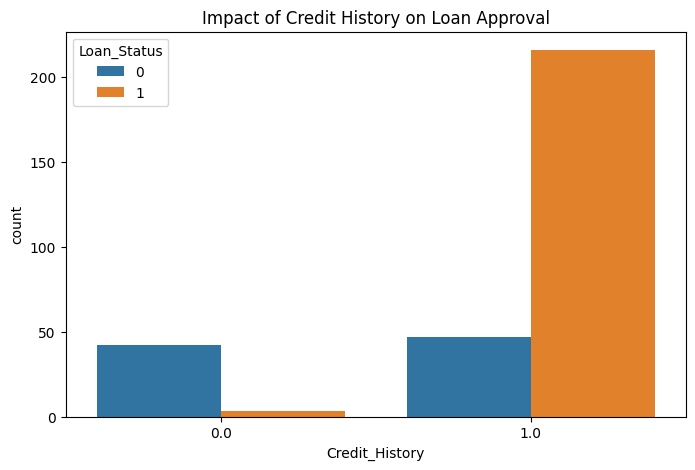

In [27]:
#impact of Credit History on Loan Approval
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit_History', hue='Loan_Status', data=loan_data)
plt.title('Impact of Credit History on Loan Approval')
plt.show()

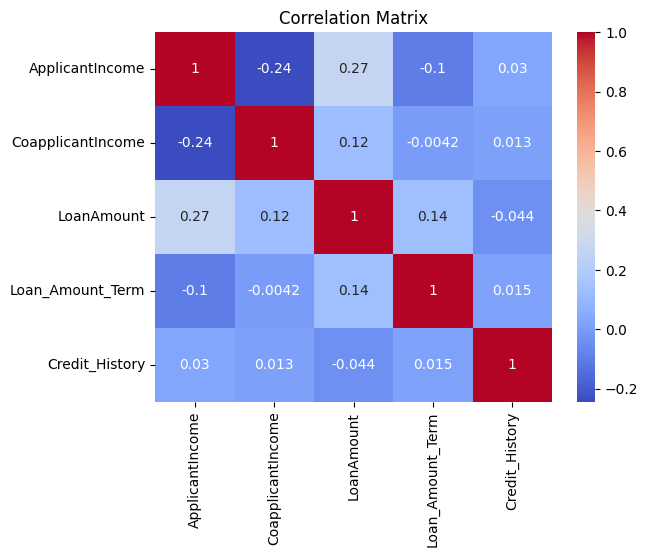

In [12]:
numerical_cols = loan_data.select_dtypes(include=[np.number]).columns

#calculate the correlation matrix excluding non-numerical columns
correlation_matrix = loan_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Feature Engineering:
    Convert categorical variables to numerical.
    Categorical features are label encoded to numeric to prepare them for modeling.

In [13]:
label_encoder = LabelEncoder()
loan_data['Gender'] = label_encoder.fit_transform(loan_data['Gender'])
loan_data['Married'] = label_encoder.fit_transform(loan_data['Married'])
loan_data['Education'] = label_encoder.fit_transform(loan_data['Education'])
loan_data['Self_Employed'] = label_encoder.fit_transform(loan_data['Self_Employed'])
loan_data['Property_Area'] = label_encoder.fit_transform(loan_data['Property_Area'])
loan_data['Loan_Status'] = label_encoder.fit_transform(loan_data['Loan_Status'])

### Data Splitting:
    The data is split 80/20 into train and test sets for modeling.

In [14]:
X = loan_data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = loan_data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#fix the issue with 'Dependents' column (it returns '3+' instead of 3)
X_train['Dependents'] = X_train['Dependents'].replace('3+', 3)
X_test['Dependents'] = X_test['Dependents'].replace('3+', 3)

#convert the 'Dependents' column to numeric
X_train['Dependents'] = pd.to_numeric(X_train['Dependents'])
X_test['Dependents'] = pd.to_numeric(X_test['Dependents'])


### Model Training and Evaluation:
    
    Two models are trained and evaluated:
    - Random Forest Classifier
    - XGBoost Classifier

In [17]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
#model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 82.26%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        20
           1       0.82      0.95      0.88        42

    accuracy                           0.82        62
   macro avg       0.83      0.75      0.77        62
weighted avg       0.83      0.82      0.81        62



#### Accuracy: 82.26% (Not bad)

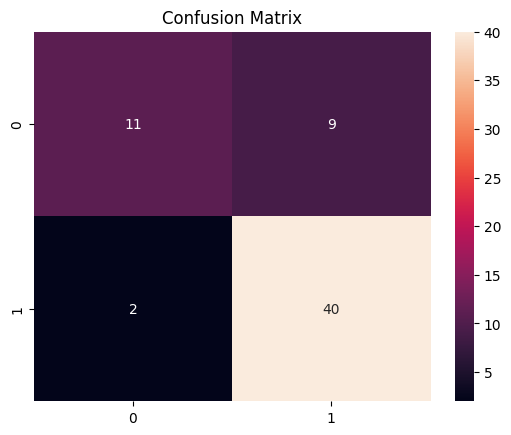

In [29]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

### To be continued...

### Feature Scaling :D

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb * 100:.2f}%')

XGBoost Accuracy: 79.03%


In [23]:
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        20
           1       0.82      0.88      0.85        42

    accuracy                           0.79        62
   macro avg       0.76      0.74      0.75        62
weighted avg       0.78      0.79      0.79        62



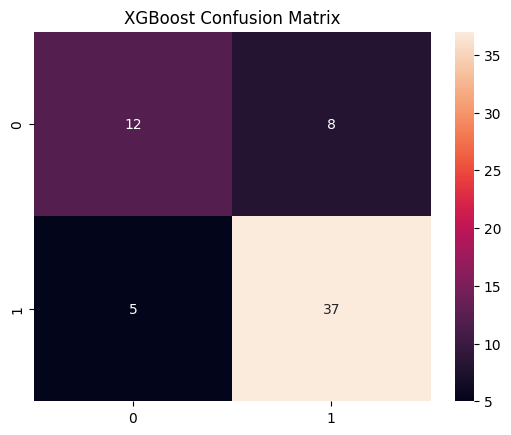

In [28]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d')
plt.title('XGBoost Confusion Matrix')
plt.show()

### Random Forest (Accuracy: 82.26%) outperforms XGBoost Classifier (Accuracy: 79.03%)

In [32]:
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

### Cross-Validation

In [33]:
# Perform 5-fold cross-validation to evaluate the model's performance
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%')

Cross-Validation Scores: [0.78       0.75510204 0.83673469 0.71428571 0.83673469]
Mean Cross-Validation Accuracy: 78.46%


In [34]:
# Perform 5-fold cross-validation to evaluate random forest model's performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%')

Cross-Validation Scores: [0.82       0.7755102  0.83673469 0.87755102 0.85714286]
Mean Cross-Validation Accuracy: 83.34%


In [39]:
from sklearn.metrics import f1_score

f1_random_forest = f1_score(y_test, y_pred, average='binary')
print(f'Random Forest F1 Score: {f1_random_forest:.4f}')

f1_xgboost = f1_score(y_test, y_pred_xgb, average='binary')
print(f'XGBoost F1 Score: {f1_xgboost:.4f}')


Random Forest F1 Score: 0.8791
XGBoost F1 Score: 0.8506


### Conclusion
In this project, data science techniques were applied to build a loan approval classifier. The best model was Random Forest with 82.26% test accuracy. The model provides a good starting point and further improvements could help increase accuracy. (More models will be added and tested for higher accuracy)